In [39]:
import os
import time
import cv2
import numpy as np
from utils import show_image

In [40]:
%matplotlib inline

Initialize bg subtraction object

In [41]:
fgbg_1 = cv2.createBackgroundSubtractorMOG2(detectShadows=False, history=50, varThreshold=16)
fgbg_2 = cv2.createBackgroundSubtractorMOG2(detectShadows=False, history=50, varThreshold=8)
fgbg_3 = cv2.createBackgroundSubtractorKNN(detectShadows=False, history=50)

Test on a stream

TODO: https://www.vegvesen.no/trafikkinformasjon/reiseinformasjon/Trafikkmeldinger/Webkamera#/vis/751511/video

In [42]:
STREAM = 'https://kamera.vegvesen.no/public/0229004_1/hls_1_stream_1_orig.m3u8'

In [43]:
vstream = None
fg = [[], [], []]
bg = None
cnt = 0
try:
    print("Started Video Stream")
    vstream = cv2.VideoCapture(STREAM)
    while True:
        ret, frame = vstream.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)            
            frame = frame[120:, 0:550, :] # Region Cropping.
            bg = frame.copy()
            fg[0].append(fgbg_1.apply(frame.copy()))
            fg[1].append(fgbg_2.apply(frame.copy()))
            fg[2].append(fgbg_3.apply(frame.copy()))
            cnt += 1
            print('Processed Frame', cnt)
        time.sleep(0.25)
except:
    print("Stopped Video Stream")
finally:
    vstream.release()

Started Video Stream
Processed Frame 1
Processed Frame 2
Processed Frame 3
Processed Frame 4
Processed Frame 5
Processed Frame 6
Processed Frame 7
Processed Frame 8
Processed Frame 9
Processed Frame 10
Processed Frame 11
Processed Frame 12
Processed Frame 13
Processed Frame 14
Processed Frame 15
Processed Frame 16
Processed Frame 17
Processed Frame 18
Processed Frame 19
Processed Frame 20
Processed Frame 21
Processed Frame 22
Processed Frame 23
Processed Frame 24
Processed Frame 25
Processed Frame 26
Processed Frame 27
Processed Frame 28
Processed Frame 29
Processed Frame 30
Processed Frame 31
Processed Frame 32
Processed Frame 33
Processed Frame 34
Processed Frame 35
Processed Frame 36
Processed Frame 37
Processed Frame 38
Processed Frame 39
Processed Frame 40
Processed Frame 41
Processed Frame 42
Processed Frame 43
Processed Frame 44
Processed Frame 45
Processed Frame 46
Processed Frame 47
Processed Frame 48
Processed Frame 49
Processed Frame 50
Processed Frame 51
Processed Frame 52


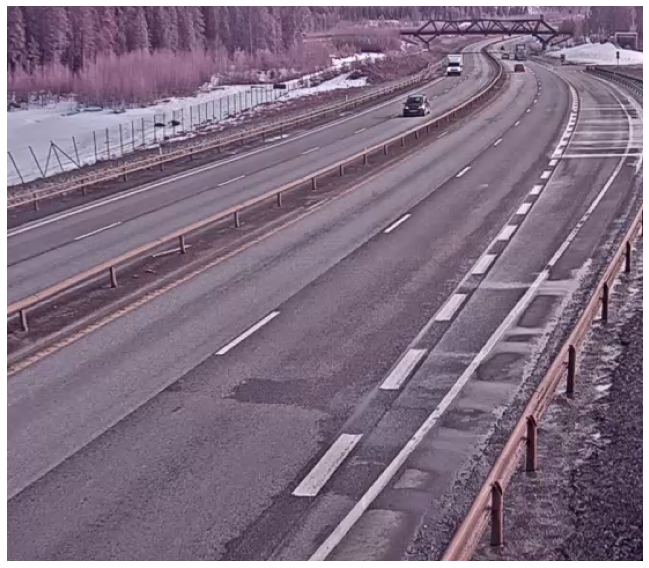

In [173]:
show_image(bg)

Extract objects

In [174]:
def extract_foreground(src, blur=5):
    src = src.copy()
    if blur > 0:
        src = cv2.medianBlur(src, blur)
    
    kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (6,6))
    kernel4 = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
    
    dilate = cv2.morphologyEx(src, cv2.MORPH_DILATE, kernel1)
    closing = cv2.morphologyEx(dilate, cv2.MORPH_CLOSE, kernel2)
    erosion = cv2.morphologyEx(closing, cv2.MORPH_ERODE, kernel3)
    opening = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel4)
    
    return opening, (opening > 0).astype(int)

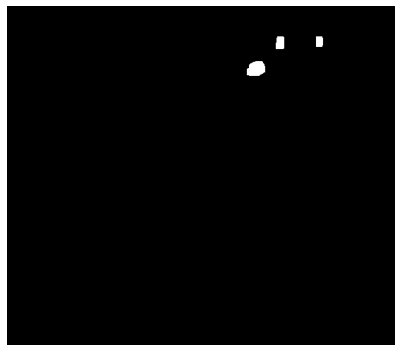

In [183]:
I, mask = extract_foreground(fg[-1][-1])
show_image(I, grayscale=True, size=(8,5))

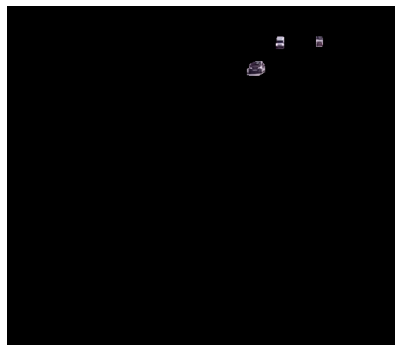

In [184]:
t = bg.copy()
for i in range(3):
    t[:,:,i] = mask*t[:,:,i]
show_image(t, size=(8,5))

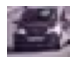

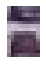

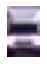

In [185]:
cnt, _ = cv2.findContours(I, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for obj in cnt:
    obj = obj.reshape(-1,2)
    x, y = [v[0] for v in obj], [v[1] for v in obj]
    x_min, x_max = min(x), max(x)
    y_min, y_max = min(y), max(y)
    show_image(bg[y_min:y_max, x_min:x_max, :], size=(2,1))